<a href="https://colab.research.google.com/github/aswinsp1102/Modelling_Team_Performance_Hurling_Collab/blob/main/Hurling_ELO_Rating_Optimizer_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Elo rating is a familiar measure of computing the relative abilities of opponents within zero-sum games, developed to use in the game of chess, but since applied in many sports, with hurling being one of them. In hurling, Elo ratings are used to measure a team strength depending upon the outcome of the match and updated after every match- Elo points are added when there is a win and an Elo is lost when there is a loss, with the range of each fairly dependent on the strength of the opponent. In this case, I will improve the system, by tuning the parameters, testing it against historic data, and make sure that his model is relevant to the intensity and unpredictability of the sport concerned.

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
import math

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/aswinsp1102/DataAnalyticsDatasets/refs/heads/main/Hurling_ELO_Ratings.csv")

In [3]:
df

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2
0,03-02-2024,League,Galway,2128,4,31.0,43,Westmeath,1518,1,12.0,15,Y,2.000000,40.0,97.07%,2.0,-2.0
1,03-02-2024,League,Dublin,1861,0,22.0,22,Tipperary,2041,2,27.0,33,Y,1.500000,40.0,46.55%,-28.0,28.0
2,03-02-2024,League,Sligo,846,4,19.0,31,Cavan,177,3,18.0,27,Y,1.148148,40.0,97.75%,1.0,-1.0
3,03-02-2024,League,Lancashire,278,0,12.0,12,Longford,412,1,9.0,12,N,1.000000,40.0,35.04%,6.0,-6.0
4,03-02-2024,League,Warwickshire,195,1,17.0,20,Leitrim,327,0,20.0,20,Y,1.000000,40.0,52.07%,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,26-07-2009,All-Ireland,Waterford,1815,1,16.0,19,Galway,1925,0,18.0,18,N,1.055556,80.0,37.60%,53.0,-53.0
2724,26-07-2009,All-Ireland,Dublin,1809,1,17.0,20,Limerick,1794,2,18.0,24,N,1.200000,80.0,51.73%,-50.0,50.0
2725,09-08-2009,All-Ireland,Kilkenny,2023,2,23.0,29,Waterford,1868,3,15.0,24,N,1.208333,80.0,67.12%,32.0,-32.0
2726,16-08-2009,All-Ireland,Tipperary,1919,6,19.0,37,Limerick,1844,2,7.0,13,N,2.000000,80.0,58.55%,66.0,-66.0


In [4]:
# Adding a column where the margin is computed without the standard capping(to the value of 2) for reference.
df['Margin_calculated'] = np.where(
    pd.to_numeric(df['Sc_1'], errors='coerce') > pd.to_numeric(df['Sc_2'], errors='coerce'),
    pd.to_numeric(df['Sc_1'], errors='coerce') / pd.to_numeric(df['Sc_2'], errors='coerce'),
    pd.to_numeric(df['Sc_2'], errors='coerce') / pd.to_numeric(df['Sc_1'], errors='coerce')
)

Formatting the date values to a uniform format and sorting them is neccessary for this study since paramters should be learned in a chronological manner

In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%d-%m-%Y')

In [6]:
df.sort_values('Date',inplace=True,ignore_index=True)

In [7]:
df

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Margin_calculated
0,2009-02-08,League,Kerry,1500,1,10.0,13,Wexford,1500,4,21.0,33,Y,2.000000,40.0,66.61%,-53.0,53.0,2.538462
1,2009-02-08,League,Derry,1100,0,9.0,9,Mayo,1100,0,6.0,6,Y,1.500000,40.0,66.61%,20.0,-20.0,1.500000
2,2009-02-08,League,South Down,600,2,9.0,15,Leitrim,600,1,12.0,15,Y,1.000000,40.0,66.61%,-7.0,7.0,1.000000
3,2009-02-14,League,Tipperary,1800,2,15.0,21,Cork,1800,0,9.0,9,Y,2.000000,40.0,66.61%,27.0,-27.0,2.333333
4,2009-02-14,League,Limerick,1800,3,13.0,22,Clare,1800,1,18.0,21,Y,1.047619,40.0,66.61%,14.0,-14.0,1.047619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,2024-06-22,All-Ireland,Dublin,1895,0,21.0,21,Cork,2190,0,26.0,26,N,1.238095,80.0,20.45%,-20.0,20.0,1.238095
2724,2024-06-22,All-Ireland,Clare,2180,2,28.0,34,Wexford,1974,1,19.0,22,N,1.545455,80.0,72.08%,35.0,-35.0,1.545455
2725,2024-07-06,All-Ireland,Kilkenny,2155,2,16.0,22,Clare,2215,0,24.0,24,N,1.090909,80.0,43.14%,-38.0,38.0,1.090909
2726,2024-07-07,All-Ireland,Limerick,2397,0,29.0,29,Cork,2210,1,28.0,31,N,1.068966,80.0,70.29%,-60.0,60.0,1.068966


In [8]:
df['Margin_calculated'].describe()

,Margin_calculated
count,2725.000000
mean,1.587219
std,0.955684
min,1.000000
25%,1.136364
50%,1.350000
75%,1.733333
max,34.000000


In [9]:
df[df['Margin_calculated'] > 5.0]

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Margin_calculated
15,2009-02-15,League,London,850,7,21.0,42,Tyrone,850,0,8.0,8,Y,2.0,40.0,66.61%,27.0,-27.0,5.250000
92,2009-04-11,League,Longford,708,1,5.0,8,London,967,7,25.0,46,Y,2.0,40.0,37.71%,-30.0,30.0,5.750000
147,2009-06-13,Secondary,Sligo,683,0,5.0,5,Armagh,1014,3,19.0,28,Y,2.0,50.0,30.29%,-30.0,30.0,5.600000
369,2011-02-13,League,Louth,829,3,20.0,29,Sligo,761,0,5.0,5,Y,2.0,40.0,73.18%,21.0,-21.0,5.800000
418,2011-03-13,League,Longford,722,6,23.0,41,Cavan,327,1,1.0,4,Y,2.0,40.0,92.48%,6.0,-6.0,10.250000
430,2011-03-13,League,Clare,1611,5,22.0,37,Down,1308,0,6.0,6,Y,2.0,40.0,88.95%,9.0,-9.0,6.166667
437,2011-03-27,League,Cavan,321,1,3.0,6,South Down,593,5,32.0,47,Y,2.0,40.0,36.31%,-29.0,29.0,7.833333
596,2012-03-25,League,Kildare,1270,7,30.0,51,Armagh,1107,0,7.0,7,Y,2.0,40.0,80.87%,15.0,-15.0,7.285714
600,2012-03-25,League,Warwickshire,542,8,19.0,43,Longford,557,0,5.0,5,Y,2.0,40.0,65.06%,28.0,-28.0,8.600000
958,2014-05-10,Secondary,Longford,539,2,17.0,23,Warwickshire,538,0,4.0,4,Y,2.0,50.0,66.72%,33.0,-33.0,5.750000


Dropping the rows with NA values in the following columns and filtering the dataset

In [10]:
columns_to_check = ['Weight', 'Grade', 'Margin','Home','Margin_calculated']

df = df.dropna(subset=columns_to_check)

In [11]:
df['Grade'].unique()

array(['League', 'Secondary', 'Ulster', 'Provincial', 'Qualifier',
       'All-Ireland'], dtype=object)

In [12]:
df['Weight'].unique()

array([40., 50., 35., 60., 80.])

In [13]:
df[df['Weight'].isna()]

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Margin_calculated


In [14]:
df[df['Home'].isna()]

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Margin_calculated


In [15]:
df = df.dropna(subset=['Weight'])

In [16]:
df

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Margin_calculated
0,2009-02-08,League,Kerry,1500,1,10.0,13,Wexford,1500,4,21.0,33,Y,2.000000,40.0,66.61%,-53.0,53.0,2.538462
1,2009-02-08,League,Derry,1100,0,9.0,9,Mayo,1100,0,6.0,6,Y,1.500000,40.0,66.61%,20.0,-20.0,1.500000
2,2009-02-08,League,South Down,600,2,9.0,15,Leitrim,600,1,12.0,15,Y,1.000000,40.0,66.61%,-7.0,7.0,1.000000
3,2009-02-14,League,Tipperary,1800,2,15.0,21,Cork,1800,0,9.0,9,Y,2.000000,40.0,66.61%,27.0,-27.0,2.333333
4,2009-02-14,League,Limerick,1800,3,13.0,22,Clare,1800,1,18.0,21,Y,1.047619,40.0,66.61%,14.0,-14.0,1.047619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,2024-06-22,All-Ireland,Dublin,1895,0,21.0,21,Cork,2190,0,26.0,26,N,1.238095,80.0,20.45%,-20.0,20.0,1.238095
2724,2024-06-22,All-Ireland,Clare,2180,2,28.0,34,Wexford,1974,1,19.0,22,N,1.545455,80.0,72.08%,35.0,-35.0,1.545455
2725,2024-07-06,All-Ireland,Kilkenny,2155,2,16.0,22,Clare,2215,0,24.0,24,N,1.090909,80.0,43.14%,-38.0,38.0,1.090909
2726,2024-07-07,All-Ireland,Limerick,2397,0,29.0,29,Cork,2210,1,28.0,31,N,1.068966,80.0,70.29%,-60.0,60.0,1.068966


'Home' Column values converted from (Y/N) string to (1/0) binary integer for better analysis using a Label Encoder

In [17]:
from sklearn.preprocessing import LabelEncoder
home_le = LabelEncoder()
df['Home'] = home_le.fit_transform(df['Home'])

In [18]:
print(sorted(df['Team 1'].unique()))
print(sorted(df['Team 2'].unique()))

['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Clare', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'FIngal', 'Fermanagh', 'Fingal', 'Galway', 'Kerry', 'Kildare', 'Kilkenny', 'Lancashire', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'South Down', 'Tipperary', 'Tyrone', 'Warwickshire', 'Waterford', 'Westmeath', 'Wexford', 'Wicklow']
['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Clare', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'Fermanagh', 'Fingal', 'Galway', 'Kerry', 'Kildare', 'Kilkenny', 'Lancashire', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'South Down', 'Tipperary', 'Tyrone', 'Warwickshire', 'Waterford', 'Westmeath', 'Wexford', 'Wicklow']


In [19]:
df = df.replace('FIngal', 'Fingal')

In [20]:
print(sorted(df['Team 1'].unique()))
print(sorted(df['Team 2'].unique()))

['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Clare', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'Fermanagh', 'Fingal', 'Galway', 'Kerry', 'Kildare', 'Kilkenny', 'Lancashire', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'South Down', 'Tipperary', 'Tyrone', 'Warwickshire', 'Waterford', 'Westmeath', 'Wexford', 'Wicklow']
['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Clare', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'Fermanagh', 'Fingal', 'Galway', 'Kerry', 'Kildare', 'Kilkenny', 'Lancashire', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'South Down', 'Tipperary', 'Tyrone', 'Warwickshire', 'Waterford', 'Westmeath', 'Wexford', 'Wicklow']


In [21]:
team_elo_values = {team: 1000 for team in sorted(df['Team 1'].unique())}
team_indices = {team : index for index,team in enumerate(sorted(df['Team 1'].unique()))}

In [22]:
grade_weight_values = {grade : 50 for grade in sorted(df['Grade'].unique())}
grade_indices = {grade : index for index,grade in enumerate(sorted(df['Grade'].unique()))}

In [23]:
df['Weight'].unique()

array([40., 50., 35., 60., 80.])

In [24]:
grade_indices

{'All-Ireland': 0,
 'League': 1,
 'Provincial': 2,
 'Qualifier': 3,
 'Secondary': 4,
 'Ulster': 5}

Creation of initial team ELO rating values refered from the ELO dataset

In [25]:
teamindex1 = {}
for index,team in enumerate(df['Team 1'].values):
  if team not in teamindex1.keys():
    teamindex1[team] = index
teamindex2 = {}
for index,team in enumerate(df['Team 2'].values):
  if team not in teamindex2.keys():
    teamindex2[team] = index
finalteamindex = {}
for team in teamindex1:
  if teamindex1[team] > teamindex2[team]:
    finalteamindex[team] =  '2_' + str(teamindex2[team])
  else:
    finalteamindex[team] =  '1_' + str(teamindex1[team])
initial_team_ratings = {}

for team,value in finalteamindex.items():
  initial_team_ratings[team] = int(df['Elo_'+ value.split('_')[0]].iloc[int(value.split('_')[1])])
team_ratings_initial = []
for team in sorted(initial_team_ratings):
  team_ratings_initial.append(initial_team_ratings[team])
team_ratings_initial

[1500,
 1100,
 1500,
 600,
 1800,
 1800,
 1100,
 850,
 1500,
 1800,
 600,
 850,
 1800,
 1500,
 1100,
 1800,
 300,
 1500,
 600,
 1800,
 850,
 850,
 850,
 1100,
 1100,
 600,
 1500,
 850,
 600,
 600,
 1800,
 850,
 600,
 1800,
 1500,
 1500,
 1100]

'Outcome' of will be a Integer classification based on WIN/LOSS/DRAW

In [26]:
df['Outcome'] = np.where(
    df['Sc_1'] > df['Sc_2'], 1,
    np.where(
        df['Sc_1'] == df['Sc_2'], 0.5,
        0
    )
)

In [27]:
df

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Margin_calculated,Outcome
0,2009-02-08,League,Kerry,1500,1,10.0,13,Wexford,1500,4,21.0,33,1,2.000000,40.0,66.61%,-53.0,53.0,2.538462,0.0
1,2009-02-08,League,Derry,1100,0,9.0,9,Mayo,1100,0,6.0,6,1,1.500000,40.0,66.61%,20.0,-20.0,1.500000,1.0
2,2009-02-08,League,South Down,600,2,9.0,15,Leitrim,600,1,12.0,15,1,1.000000,40.0,66.61%,-7.0,7.0,1.000000,0.5
3,2009-02-14,League,Tipperary,1800,2,15.0,21,Cork,1800,0,9.0,9,1,2.000000,40.0,66.61%,27.0,-27.0,2.333333,0.0
4,2009-02-14,League,Limerick,1800,3,13.0,22,Clare,1800,1,18.0,21,1,1.047619,40.0,66.61%,14.0,-14.0,1.047619,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,2024-06-22,All-Ireland,Dublin,1895,0,21.0,21,Cork,2190,0,26.0,26,0,1.238095,80.0,20.45%,-20.0,20.0,1.238095,0.0
2724,2024-06-22,All-Ireland,Clare,2180,2,28.0,34,Wexford,1974,1,19.0,22,0,1.545455,80.0,72.08%,35.0,-35.0,1.545455,1.0
2725,2024-07-06,All-Ireland,Kilkenny,2155,2,16.0,22,Clare,2215,0,24.0,24,0,1.090909,80.0,43.14%,-38.0,38.0,1.090909,0.0
2726,2024-07-07,All-Ireland,Limerick,2397,0,29.0,29,Cork,2210,1,28.0,31,0,1.068966,80.0,70.29%,-60.0,60.0,1.068966,0.0


In [28]:
df_c = df.copy()


In [29]:
num_teams = len(df['Team 1'].unique())
num_grades = len(df['Grade'].unique())

In [30]:
np.array(list(grade_weight_values.values()))

array([50, 50, 50, 50, 50, 50])

In [31]:
class Rating_Layer(Layer):
  def __init__(self,num_teams,num_grades,initial_rating=1000.0, **kwargs):
      super(Rating_Layer,self).__init__(**kwargs)
      self.num_teams = num_teams
      self.num_grades = num_grades
      self.initial_rating = initial_rating

  def build(self, input_shape):
     self.scaling_factor = self.add_weight(
            name='scaling_factor',
            shape=(1,),
            initializer=tf.keras.initializers.Constant(500.0), # Scaling factor is initialized to 500 and allowed to train capped between 300 to 800.
            trainable=True,
            constraint=tf.keras.constraints.MinMaxNorm(min_value=300.0, max_value=800.0)
        )
     self.grade_weights = self.add_weight(
            name='grade_weights',
            shape=(self.num_grades,),
            initializer=tf.keras.initializers.Constant([50.0]* num_grades), # All the grade weights are initialized to 50
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )
     self.base = self.add_weight(
         name = 'base',
         shape = (1,),
         initializer = tf.keras.initializers.Constant(math.e), # Base value used in the Expectation formula is fixed to the Eulers constant
         trainable = False
        )
     self.home_advantage_points = self.add_weight(
            name='home_advantage_points',
            shape=(1,),
            initializer=tf.keras.initializers.Constant(100.0), # Home advantage points is allowed to train intitialized at a value of 100
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )
     self.team_ratings = self.add_weight(
            name='team_ratings',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant([self.initial_rating]*num_teams),
            trainable=False,
            constraint=tf.keras.constraints.NonNeg()
        )

     self.outcome = self.add_weight(
            name='outcome',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant([0.0]*num_teams),
            trainable=False
        )

     self.expectation = self.add_weight(
            name='expectation',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant([0.0]*num_teams),
            trainable=False
        )
     self.team_number_flag = self.add_weight(
            name='team_number_flag',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant([1.0]*num_teams),
            trainable=False
        )
     super(Rating_Layer,self).build(input_shape)

  def call(self,inputs):
        team1_i, team2_i, grade_indx, home, margin,outcome = inputs

        W = tf.gather(self.grade_weights, grade_indx)
        sc_factor = self.scaling_factor
        b = self.base
        H = self.home_advantage_points

        flag_team1 = tf.gather(self.team_number_flag, team1_i)
        flag_team2 = tf.gather(self.team_number_flag, team2_i)

        team_1_rating = tf.where(
            tf.equal(flag_team1, 1.0),
            tf.gather(self.team_ratings, team1_i) + (W * margin * (tf.gather(self.outcome, team1_i) - tf.gather(self.expectation, team1_i)))  + tf.where(tf.equal(home, 1), H, 0.0),
            tf.gather(self.team_ratings, team1_i) - (W * margin * (tf.gather(self.outcome, team1_i) - tf.gather(self.expectation, team1_i)))  + tf.where(tf.equal(home, 1), H, 0.0)
        )

        team_2_rating = tf.where(
            tf.equal(flag_team2, 1.0),
            tf.gather(self.team_ratings, team2_i) + (W * margin * (tf.gather(self.outcome, team2_i) - tf.gather(self.expectation, team2_i))),
            tf.gather(self.team_ratings, team2_i) - (W * margin * (tf.gather(self.outcome, team2_i) - tf.gather(self.expectation, team2_i)))
        )

        rating_diff = team_1_rating  - team_2_rating
        E = 1 / (1 + tf.pow(b, -rating_diff / sc_factor))

        updated_flag =  tf.tensor_scatter_nd_update(self.team_number_flag,
                                                      indices=team1_i,
                                                      updates=tf.reshape(1.0,[-1]))
        self.team_number_flag.assign(updated_flag)

        updated_flag =  tf.tensor_scatter_nd_update(self.team_number_flag,
                                                      indices=team2_i,
                                                      updates=tf.reshape(0.0,[-1]))
        self.team_number_flag.assign(updated_flag)


        #############
        updated_expectations =  tf.tensor_scatter_nd_update(self.expectation,
                                                      indices=team1_i,
                                                      updates=tf.reshape(E,[-1]))
        self.expectation.assign(updated_expectations)

        updated_expectations =  tf.tensor_scatter_nd_update(self.expectation,
                                                      indices=team2_i,
                                                      updates=tf.reshape(E,[-1]))
        self.expectation.assign(updated_expectations)
        ##################

        updated_outcomes =  tf.tensor_scatter_nd_update(self.outcome,
                                                      indices=team1_i,
                                                      updates=tf.reshape(outcome,[-1]))
        self.outcome.assign(updated_outcomes)

        updated_outcomes =  tf.tensor_scatter_nd_update(self.outcome,
                                                      indices=team2_i,
                                                      updates=tf.reshape(outcome,[-1]))
        self.outcome.assign(updated_outcomes)
        #####################

        updated_ratings_team1 = tf.tensor_scatter_nd_update(self.team_ratings,
                                                      indices=team1_i,
                                                      updates=tf.reshape(team_1_rating - tf.where(tf.equal(home, 1), H, 0.0) ,[-1]))

        self.team_ratings.assign(updated_ratings_team1)

        updated_ratings_team2 = tf.tensor_scatter_nd_update(self.team_ratings,
                                                      indices=team2_i,
                                                      updates=tf.reshape(team_2_rating,[-1]))

        self.team_ratings.assign(updated_ratings_team2)

        return E

In [32]:
from tensorflow.keras.callbacks import Callback

class ResetRatingsCallback(Callback):

    def __init__(self, rating_layer, initial_rating=1000.0):

        super().__init__()

        self.rating_layer = rating_layer

        self.initial_rating = initial_rating

    def on_epoch_begin(self, epoch, logs=None):


        self.rating_layer.team_ratings.assign(

            tf.ones_like(self.rating_layer.team_ratings) * self.initial_rating

        )
        self.rating_layer.outcome.assign(

            tf.zeros_like(self.rating_layer.outcome)

        )
        self.rating_layer.expectation.assign(

            tf.zeros_like(self.rating_layer.expectation)

        )
        self.rating_layer.team_number_flag.assign(

            tf.ones_like(self.rating_layer.team_number_flag)

        )
        # print(f"\nRatings reset to {self.initial_rating} after epoch {epoch+1}")

In [33]:
def Rating_model(num_teams,num_grades):
    team1 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team1')
    team2 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team2')
    grade = tf.keras.Input(shape=(1,), dtype=tf.int32, name='grade')
    home = tf.keras.Input(shape=(1,), dtype=tf.int32, name='home')
    margin = tf.keras.Input(shape=(1,),dtype=tf.float32,name='margin')
    outcome = tf.keras.Input(shape=(1,),dtype=tf.float32,name='outcome')

    model = tf.keras.Model(
        inputs=[team1, team2, grade, home,margin,outcome],
        outputs=(Rating_Layer(num_teams, num_grades)([team1, team2, grade, home,margin,outcome]))
    )

    return model

In [34]:
df = df_c
team_1_index = df['Team 1'].map(team_indices).values.reshape(-1, 1)
team_2_index = df['Team 2'].map(team_indices).values.reshape(-1, 1)
grade_index = df['Grade'].map(grade_indices).values.reshape(-1,1)
home_values = df['Home'].values.reshape(-1,1)
outcome_values = df['Outcome'].values.reshape(-1,1)
margin_values = df['Margin'].values.reshape(-1,1)
# df['Sc_1'].values.reshape(-1,1).astype(np.float32)
# df['Sc_2'].values.reshape(-1,1).astype(np.float32)


In [35]:
Optimization_Rating_model = Rating_model(num_teams , num_grades)

rating_layer = Optimization_Rating_model.layers[-1]
reset_callback = ResetRatingsCallback(rating_layer, initial_rating=1000.0)

Optimization_Rating_model.compile(optimizer=Adam(learning_rate=0.001),
                                  loss=tf.keras.losses.BinaryCrossentropy(),
                                  metrics=['mse'])

In [36]:
model_history = Optimization_Rating_model.fit(
    x={
        'team1': team_1_index,
        'team2': team_2_index,
        'grade': grade_index,
        'home': home_values,
        'margin': margin_values,
        'outcome': outcome_values
    },
    y=outcome_values,
    epochs=20,
    batch_size=1,
    verbose=1,
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs/rating_model/', histogram_freq=1), reset_callback],
    shuffle = False
)

Epoch 1/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 2/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 3/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 4/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 5/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 6/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 7/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 8/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6780 - mse: 0.2298
Epoch 9/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6781 - mse: 0.2298
Epoch 10/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6781 - mse: 0.2298
Epoch 11/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6781 - mse: 0.2299
Epoch 12/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6781 - mse: 0.22

In [37]:
Rating_Layer_calculated = Optimization_Rating_model.layers[-1]

optimized_params = {
    'Grade_weights': Rating_Layer_calculated.grade_weights.numpy(),
    'scaling_factor': Rating_Layer_calculated.scaling_factor.numpy()[0],
    'base': Rating_Layer_calculated.base.numpy()[0],
    'home_advantage_point': Rating_Layer_calculated.home_advantage_points.numpy()[0],
    'team_ratings': Rating_Layer_calculated.team_ratings.numpy()
}

In [38]:
print("Optimized Parameters:")
for key, value in optimized_params.items():
    if key != 'team_ratings' :
        print(f"{key}: {value}")

Optimized Parameters:
Grade_weights: [47.732796 53.413624 50.392193 49.705833 52.500614 52.03584 ]
scaling_factor: 500.82025146484375
base: 2.7182817459106445
home_advantage_point: 100.65667724609375


In [39]:
for key,value in team_indices.items():
  print(f"{key}: {optimized_params['team_ratings'][value]:.0f}")

Antrim: 844
Armagh: 628
Carlow: 1028
Cavan: 491
Clare: 1614
Cork: 1672
Derry: 1203
Donegal: 1086
Down: 790
Dublin: 1299
Fermanagh: 465
Fingal: 951
Galway: 1551
Kerry: 795
Kildare: 1140
Kilkenny: 1538
Lancashire: 196
Laois: 1055
Leitrim: 417
Limerick: 1928
London: 784
Longford: 489
Louth: 437
Mayo: 814
Meath: 620
Monaghan: 451
Offaly: 1196
Roscommon: 828
Sligo: 604
South Down: 837
Tipperary: 1393
Tyrone: 866
Warwickshire: 494
Waterford: 1233
Westmeath: 884
Wexford: 1425
Wicklow: 643


In [40]:
# %load_ext tensorboard

In [41]:
# %tensorboard --logdir "./logs/rating_model"

In [42]:
rating_layer.team_ratings.assign(

            tf.ones_like(rating_layer.team_ratings) * 1000.0

        )
rating_layer.outcome.assign(

            tf.zeros_like(rating_layer.outcome)

        )
rating_layer.expectation.assign(

            tf.zeros_like(rating_layer.expectation)

        )
rating_layer.team_number_flag.assign(

            tf.ones_like(rating_layer.team_number_flag)

        )

<tf.Tensor: shape=(37,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>

In [43]:
E_prediction_results = Optimization_Rating_model.predict(
    x={
        'team1': team_1_index,
        'team2': team_2_index,
        'grade': grade_index,
        'home': home_values,
        'margin': margin_values,
        'outcome': outcome_values
    },
    batch_size = 1,
    verbose = 'auto'
)

2725/2725 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


**Finding the Optimal Initial team rating values**



In [44]:
#1.. fix the initial raining as 1000 for all the teams and run the model through 3 years to find an initial opitmal team ratings
#2.. Then use these initial team ratings and run through the simluation to find optimal parameters
#3.. now using these paramters , find team ratings at the end of 2024
#4.. now run backwards, in time to find the ratings at the start of 2009

Initially, ratings are fixed as 1000 for all the teams and model is run through a time period of 3 years(Stabilization period) to find a set of initial team ratings. A total of 539 matches where played in the period of 2009-2012, which we take it as the first batch to find a new set of initial team ratings

In [45]:
rating_layer.team_ratings.assign(

            tf.ones_like(rating_layer.team_ratings) * 1000.0

        )
rating_layer.outcome.assign(

            tf.zeros_like(rating_layer.outcome)

        )
rating_layer.expectation.assign(

            tf.zeros_like(rating_layer.expectation)

        )
rating_layer.team_number_flag.assign(

            tf.ones_like(rating_layer.team_number_flag)

        )

<tf.Tensor: shape=(37,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>

In [46]:
team_rating_initializer = Optimization_Rating_model.predict(
    x={
        'team1': team_1_index[:540],
        'team2': team_2_index[:540],
        'grade': grade_index[:540],
        'home': home_values[:540],
        'margin': margin_values[:540],
        'outcome': outcome_values[:540]
    },
    batch_size = 1,
    verbose = 'auto'
)

540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


The following are the new initial team ratings for the optimization model

In [47]:
for key,value in team_indices.items():
  print(f"{key}: {rating_layer.team_ratings[value]:.0f}")

Antrim: 1058
Armagh: 1246
Carlow: 1078
Cavan: 660
Clare: 799
Cork: 1006
Derry: 772
Donegal: 899
Down: 805
Dublin: 1197
Fermanagh: 942
Fingal: 1028
Galway: 1204
Kerry: 922
Kildare: 911
Kilkenny: 1440
Lancashire: 1000
Laois: 854
Leitrim: 848
Limerick: 1066
London: 1211
Longford: 1006
Louth: 860
Mayo: 875
Meath: 1123
Monaghan: 1005
Offaly: 765
Roscommon: 981
Sligo: 795
South Down: 837
Tipperary: 1388
Tyrone: 1163
Warwickshire: 908
Waterford: 1138
Westmeath: 761
Wexford: 1061
Wicklow: 1227


In [48]:
#1.. This is the observed ratings that is to be used as initial ratings for the next set of run
rating_layer.team_ratings.value

<tf.Variable 'rating__layer/team_ratings:0' shape=(37,) dtype=float32, numpy=
array([1057.7708 , 1246.3591 , 1077.9083 ,  659.7943 ,  799.0687 ,
       1005.5711 ,  771.91345,  899.1951 ,  804.55774, 1197.0977 ,
        942.289  , 1027.9904 , 1203.6254 ,  922.3302 ,  911.3042 ,
       1440.238  , 1000.     ,  854.4271 ,  848.204  , 1066.1486 ,
       1211.456  , 1005.60474,  860.2201 ,  874.7824 , 1123.1497 ,
       1004.9431 ,  765.38763,  981.4744 ,  795.3949 ,  837.0593 ,
       1387.8254 , 1162.7393 ,  907.50244, 1138.4958 ,  761.209  ,
       1060.7601 , 1226.6227 ], dtype=float32)>

Use the set of ratings as the initial ratings to run forward in time to get optimal paramters and latest team rankings at the end of 2024

In [49]:
class Rating_Layer_updated(Layer):
  def __init__(self,num_teams,num_grades,initial_rating, **kwargs):
      super(Rating_Layer_updated,self).__init__(**kwargs)
      self.num_teams = num_teams
      self.num_grades = num_grades
      self.initial_rating = initial_rating

  def build(self, input_shape):
     self.scaling_factor = self.add_weight(
            name='scaling_factor',
            shape=(1,),
            initializer=tf.keras.initializers.Constant(500.0),
            trainable=True,
            constraint=tf.keras.constraints.MinMaxNorm(min_value=300.0, max_value=800.0)
        )
     self.grade_weights = self.add_weight(
            name='grade_weights',
            shape=(self.num_grades,),
            initializer=tf.keras.initializers.Constant([50.0]* num_grades),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )
     self.base = self.add_weight(
         name = 'base',
         shape = (1,),
         initializer = tf.keras.initializers.Constant(math.e),
         trainable = False,
         constraint=tf.keras.constraints.MinMaxNorm(min_value=5.0, max_value=20.0)
        )
     self.home_advantage_points = self.add_weight(
            name='home_advantage_points',
            shape=(1,),
            initializer=tf.keras.initializers.Constant(100.0),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )
     self.team_ratings = self.add_weight(
            name='team_ratings',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant(self.initial_rating),
            trainable=False,
            constraint=tf.keras.constraints.NonNeg()
        )

     self.outcome = self.add_weight(
            name='outcome',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant([0.0]*num_teams),
            trainable=False
        )

     self.expectation = self.add_weight(
            name='expectation',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant([0.0]*num_teams),
            trainable=False
        )
     self.team_number_flag = self.add_weight(
            name='team_number_flag',
            shape=(self.num_teams,),
            initializer=tf.keras.initializers.Constant([1.0]*num_teams),
            trainable=False
        )
     super(Rating_Layer_updated,self).build(input_shape)

  def call(self,inputs):
        team1_i, team2_i, grade_indx, home, margin,outcome = inputs

        W = tf.gather(self.grade_weights, grade_indx)
        sc_factor = self.scaling_factor
        b = self.base
        H = self.home_advantage_points

        flag_team1 = tf.gather(self.team_number_flag, team1_i)
        flag_team2 = tf.gather(self.team_number_flag, team2_i)

        team_1_rating = tf.where(
            tf.equal(flag_team1, 1.0),
            tf.gather(self.team_ratings, team1_i) + (W * margin * (tf.gather(self.outcome, team1_i) - tf.gather(self.expectation, team1_i)))  + tf.where(tf.equal(home, 1), H, 0.0),
            tf.gather(self.team_ratings, team1_i) - (W * margin * (tf.gather(self.outcome, team1_i) - tf.gather(self.expectation, team1_i)))  + tf.where(tf.equal(home, 1), H, 0.0)
        )

        team_2_rating = tf.where(
            tf.equal(flag_team2, 1.0),
            tf.gather(self.team_ratings, team2_i) + (W * margin * (tf.gather(self.outcome, team2_i) - tf.gather(self.expectation, team2_i))),
            tf.gather(self.team_ratings, team2_i) - (W * margin * (tf.gather(self.outcome, team2_i) - tf.gather(self.expectation, team2_i)))
        )

        rating_diff = team_1_rating  - team_2_rating
        E = 1 / (1 + tf.pow(b, -rating_diff / sc_factor))

        updated_flag =  tf.tensor_scatter_nd_update(self.team_number_flag,
                                                      indices=team1_i,
                                                      updates=tf.reshape(1.0,[-1]))
        self.team_number_flag.assign(updated_flag)

        updated_flag =  tf.tensor_scatter_nd_update(self.team_number_flag,
                                                      indices=team2_i,
                                                      updates=tf.reshape(0.0,[-1]))
        self.team_number_flag.assign(updated_flag)


        #############
        updated_expectations =  tf.tensor_scatter_nd_update(self.expectation,
                                                      indices=team1_i,
                                                      updates=tf.reshape(E,[-1]))
        self.expectation.assign(updated_expectations)

        updated_expectations =  tf.tensor_scatter_nd_update(self.expectation,
                                                      indices=team2_i,
                                                      updates=tf.reshape(E,[-1]))
        self.expectation.assign(updated_expectations)
        ##################

        updated_outcomes =  tf.tensor_scatter_nd_update(self.outcome,
                                                      indices=team1_i,
                                                      updates=tf.reshape(outcome,[-1]))
        self.outcome.assign(updated_outcomes)

        updated_outcomes =  tf.tensor_scatter_nd_update(self.outcome,
                                                      indices=team2_i,
                                                      updates=tf.reshape(outcome,[-1]))
        self.outcome.assign(updated_outcomes)
        #####################

        updated_ratings_team1 = tf.tensor_scatter_nd_update(self.team_ratings,
                                                      indices=team1_i,
                                                      updates=tf.reshape(team_1_rating - tf.where(tf.equal(home, 1), H, 0.0) ,[-1]))

        self.team_ratings.assign(updated_ratings_team1)

        updated_ratings_team2 = tf.tensor_scatter_nd_update(self.team_ratings,
                                                      indices=team2_i,
                                                      updates=tf.reshape(team_2_rating,[-1]))

        self.team_ratings.assign(updated_ratings_team2)

        return E

In [50]:
class ResetRatingsCallback_updated(Callback):
    def __init__(self, rating_layer_updated, initial_rating):
        super().__init__()
        self.rating_layer_updated = rating_layer_updated
        self.initial_rating = initial_rating
    def on_epoch_begin(self, epoch, logs=None):
        self.rating_layer_updated.team_ratings.assign(
            self.initial_rating
        )
        self.rating_layer_updated.outcome.assign(
            tf.zeros_like(self.rating_layer_updated.outcome)
        )
        self.rating_layer_updated.expectation.assign(
            tf.zeros_like(self.rating_layer_updated.expectation)
        )
        self.rating_layer_updated.team_number_flag.assign(
            tf.ones_like(self.rating_layer_updated.team_number_flag)
        )
        # print(f"\nRatings reset to {self.initial_rating} after epoch {epoch+1}")

In [51]:
def Rating_model_updated(num_teams,num_grades):
    team1 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team1')
    team2 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team2')
    grade = tf.keras.Input(shape=(1,), dtype=tf.int32, name='grade')
    home = tf.keras.Input(shape=(1,), dtype=tf.int32, name='home')
    margin = tf.keras.Input(shape=(1,),dtype=tf.float32,name='margin')
    outcome = tf.keras.Input(shape=(1,),dtype=tf.float32,name='outcome')

    model = tf.keras.Model(
        inputs=[team1, team2, grade, home,margin,outcome],
        outputs=(Rating_Layer_updated(num_teams, num_grades,rating_layer.team_ratings.value)([team1, team2, grade, home,margin,outcome]))
    )

    return model

df = df_c
team_1_index = df['Team 1'].map(team_indices).values.reshape(-1, 1)
team_2_index = df['Team 2'].map(team_indices).values.reshape(-1, 1)
grade_index = df['Grade'].map(grade_indices).values.reshape(-1,1)
home_values = df['Home'].values.reshape(-1,1)
outcome_values = df['Outcome'].values.reshape(-1,1)
margin_values = df['Margin'].values.reshape(-1,1)

In [52]:
Optimization_Rating_model_updated = Rating_model_updated(num_teams , num_grades)

rating_layer_updated = Optimization_Rating_model_updated.layers[-1]
reset_callback_updated = ResetRatingsCallback_updated(rating_layer_updated, initial_rating=rating_layer.team_ratings.value)

Optimization_Rating_model_updated.compile(optimizer=Adam(learning_rate=0.001),
                                  loss=tf.keras.losses.BinaryCrossentropy(),
                                  metrics=['mse'])

In [53]:
model_history = Optimization_Rating_model_updated.fit(
    x={
        'team1': team_1_index,
        'team2': team_2_index,
        'grade': grade_index,
        'home': home_values,
        'margin': margin_values,
        'outcome': outcome_values
    },
    y=outcome_values,
    epochs=20,
    batch_size=1,
    verbose=1,
    callbacks = [reset_callback_updated],
    shuffle = False
)

Epoch 1/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6595 - mse: 0.2208
Epoch 2/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6595 - mse: 0.2208
Epoch 3/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6595 - mse: 0.2209
Epoch 4/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6596 - mse: 0.2209
Epoch 5/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6596 - mse: 0.2209
Epoch 6/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6596 - mse: 0.2209
Epoch 7/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6596 - mse: 0.2209
Epoch 8/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6596 - mse: 0.2209
Epoch 9/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6597 - mse: 0.2209
Epoch 10/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6597 - mse: 0.2209
Epoch 11/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6597 - mse: 0.2209
Epoch 12/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6597 - mse: 0.

In [54]:
Rating_Layer_updated_calculated = Optimization_Rating_model_updated.layers[-1]

optimized_params_updated = {
    'Grade_weights': Rating_Layer_updated_calculated.grade_weights.numpy(),
    'scaling_factor': Rating_Layer_updated_calculated.scaling_factor.numpy()[0],
    'base': Rating_Layer_updated_calculated.base.numpy()[0],
    'home_advantage_point': Rating_Layer_updated_calculated.home_advantage_points.numpy()[0],
    'team_ratings': Rating_Layer_updated_calculated.team_ratings.numpy()
}

In [55]:
print("Optimized Parameters:")
for key, value in optimized_params_updated.items():
    if key != 'team_ratings' :
        print(f"{key}: {value}")

Optimized Parameters:
Grade_weights: [47.70346  53.21895  50.46981  49.564022 52.39294  52.05295 ]
scaling_factor: 500.5299987792969
base: 2.7182817459106445
home_advantage_point: 100.71732330322266


In [56]:
for key,value in team_indices.items():
  print(f"{key}: {optimized_params_updated['team_ratings'][value]:.0f}")

Antrim: 881
Armagh: 594
Carlow: 1044
Cavan: 424
Clare: 1679
Cork: 1738
Derry: 1182
Donegal: 1056
Down: 793
Dublin: 1356
Fermanagh: 410
Fingal: 932
Galway: 1613
Kerry: 803
Kildare: 1132
Kilkenny: 1600
Lancashire: 140
Laois: 1077
Leitrim: 358
Limerick: 1995
London: 763
Longford: 435
Louth: 394
Mayo: 783
Meath: 620
Monaghan: 409
Offaly: 1217
Roscommon: 796
Sligo: 570
South Down: 716
Tipperary: 1461
Tyrone: 838
Warwickshire: 445
Waterford: 1301
Westmeath: 916
Wexford: 1482
Wicklow: 621


Now running backwards in time to get the initial values of the team ratings at the start of 2009

In [57]:
optimized_params_updated['team_ratings']

array([ 881.1957 ,  593.72327, 1044.1368 ,  424.3925 , 1679.2102 ,
       1737.7982 , 1181.6285 , 1056.1101 ,  792.70557, 1356.0527 ,
        410.11584,  932.3647 , 1612.8702 ,  802.63324, 1132.0664 ,
       1600.4625 ,  140.23549, 1076.8279 ,  358.24756, 1994.6708 ,
        762.62085,  434.795  ,  393.58334,  783.4045 ,  619.5394 ,
        409.4862 , 1217.2858 ,  796.2513 ,  570.4905 ,  716.1746 ,
       1460.9094 ,  838.0077 ,  444.60635, 1301.2212 ,  916.3131 ,
       1481.5084 ,  621.1742 ], dtype=float32)

In [58]:
def Rating_model_updated(num_teams,num_grades):
    team1 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team1')
    team2 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team2')
    grade = tf.keras.Input(shape=(1,), dtype=tf.int32, name='grade')
    home = tf.keras.Input(shape=(1,), dtype=tf.int32, name='home')
    margin = tf.keras.Input(shape=(1,),dtype=tf.float32,name='margin')
    outcome = tf.keras.Input(shape=(1,),dtype=tf.float32,name='outcome')

    model = tf.keras.Model(
        inputs=[team1, team2, grade, home,margin,outcome],
        outputs=(Rating_Layer_updated(num_teams, num_grades,optimized_params_updated['team_ratings'])([team1, team2, grade, home,margin,outcome]))
    )

    return model

In [59]:
df_c = df.copy()
df_c.sort_values('Date',inplace=True,ignore_index=True,ascending = False)
team_1_index = df_c['Team 1'].map(team_indices).values.reshape(-1, 1)
team_2_index = df_c['Team 2'].map(team_indices).values.reshape(-1, 1)
grade_index = df_c['Grade'].map(grade_indices).values.reshape(-1,1)
home_values = df_c['Home'].values.reshape(-1,1)
outcome_values = df_c['Outcome'].values.reshape(-1,1)
margin_values = df_c['Margin'].values.reshape(-1,1)

In [60]:
Optimization_Rating_model_updated = Rating_model_updated(num_teams , num_grades)

rating_layer_updated = Optimization_Rating_model_updated.layers[-1]
reset_callback_updated = ResetRatingsCallback_updated(rating_layer_updated, initial_rating=optimized_params_updated['team_ratings'])

Optimization_Rating_model_updated.compile(optimizer=Adam(learning_rate=0.001),
                                  loss=tf.keras.losses.BinaryCrossentropy(),
                                  metrics=['mse'])

In [61]:
model_history = Optimization_Rating_model_updated.fit(
    x={
        'team1': team_1_index,
        'team2': team_2_index,
        'grade': grade_index,
        'home': home_values,
        'margin': margin_values,
        'outcome': outcome_values
    },
    y=outcome_values,
    epochs=20,
    batch_size=1,
    verbose=1,
    callbacks = [reset_callback_updated],
    shuffle = False
)

Epoch 1/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.6155 - mse: 0.1957
Epoch 2/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6156 - mse: 0.1957
Epoch 3/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6156 - mse: 0.1957
Epoch 4/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6156 - mse: 0.1957
Epoch 5/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6156 - mse: 0.1957
Epoch 6/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6156 - mse: 0.1957
Epoch 7/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6156 - mse: 0.1957
Epoch 8/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6156 - mse: 0.1958
Epoch 9/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6156 - mse: 0.1958
Epoch 10/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6156 - mse: 0.1958
Epoch 11/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6156 - mse: 0.1958
Epoch 12/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6156 - mse: 0.1

In [62]:
Rating_Layer_updated_calculated = Optimization_Rating_model_updated.layers[-1]

optimized_params_updated = {
    'Grade_weights': Rating_Layer_updated_calculated.grade_weights.numpy(),
    'scaling_factor': Rating_Layer_updated_calculated.scaling_factor.numpy()[0],
    'base': Rating_Layer_updated_calculated.base.numpy()[0],
    'home_advantage_point': Rating_Layer_updated_calculated.home_advantage_points.numpy()[0],
    'team_ratings': Rating_Layer_updated_calculated.team_ratings.numpy()
}

In [63]:
print("Optimized Parameters:")
for key, value in optimized_params_updated.items():
    if key != 'team_ratings' :
        print(f"{key}: {value}")

Optimized Parameters:
Grade_weights: [48.75721  51.999897 48.93869  49.04708  52.59101  50.15659 ]
scaling_factor: 499.8208312988281
base: 2.7182817459106445
home_advantage_point: 100.81473541259766


In [64]:
for key,value in team_indices.items():
  print(f"{key}: {rating_layer_updated.team_ratings[value]:.0f}")

Antrim: 1049
Armagh: 857
Carlow: 1168
Cavan: 30
Clare: 1513
Cork: 1771
Derry: 589
Donegal: 496
Down: 927
Dublin: 1704
Fermanagh: 410
Fingal: 751
Galway: 1992
Kerry: 864
Kildare: 791
Kilkenny: 2347
Lancashire: 20
Laois: 1054
Leitrim: 173
Limerick: 1609
London: 958
Longford: 343
Louth: 194
Mayo: 605
Meath: 906
Monaghan: 576
Offaly: 1177
Roscommon: 559
Sligo: 311
South Down: 342
Tipperary: 2111
Tyrone: 695
Warwickshire: 366
Waterford: 1864
Westmeath: 737
Wexford: 1432
Wicklow: 881


Taking these as the final Optimal initial ratings to track the rating model again forward in time period of study

In [65]:
final_intitial_ratings = rating_layer_updated.team_ratings.value

In [66]:
def Rating_model_updated(num_teams,num_grades):
    team1 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team1')
    team2 = tf.keras.Input(shape=(1,), dtype=tf.int32, name='team2')
    grade = tf.keras.Input(shape=(1,), dtype=tf.int32, name='grade')
    home = tf.keras.Input(shape=(1,), dtype=tf.int32, name='home')
    margin = tf.keras.Input(shape=(1,),dtype=tf.float32,name='margin')
    outcome = tf.keras.Input(shape=(1,),dtype=tf.float32,name='outcome')

    model = tf.keras.Model(
        inputs=[team1, team2, grade, home,margin,outcome],
        outputs=(Rating_Layer_updated(num_teams, num_grades,final_intitial_ratings)([team1, team2, grade, home,margin,outcome]))
    )

    return model

team_1_index = df['Team 1'].map(team_indices).values.reshape(-1, 1)
team_2_index = df['Team 2'].map(team_indices).values.reshape(-1, 1)
grade_index = df['Grade'].map(grade_indices).values.reshape(-1,1)
home_values = df['Home'].values.reshape(-1,1)
outcome_values = df['Outcome'].values.reshape(-1,1)
margin_values = df['Margin'].values.reshape(-1,1)

In [67]:
Optimization_Rating_model_updated = Rating_model_updated(num_teams , num_grades)

rating_layer_updated = Optimization_Rating_model_updated.layers[-1]
reset_callback_updated = ResetRatingsCallback_updated(rating_layer_updated, initial_rating=final_intitial_ratings)

Optimization_Rating_model_updated.compile(optimizer=Adam(learning_rate=0.001),
                                  loss=tf.keras.losses.BinaryCrossentropy(),
                                  metrics=['mse'])

In [68]:
model_history = Optimization_Rating_model_updated.fit(
    x={
        'team1': team_1_index,
        'team2': team_2_index,
        'grade': grade_index,
        'home': home_values,
        'margin': margin_values,
        'outcome': outcome_values
    },
    y=outcome_values,
    epochs=20,
    batch_size=1,
    verbose=1,
    callbacks = [reset_callback_updated],
    shuffle = False
)

Epoch 1/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 2/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 3/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 4/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 5/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 6/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 7/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 8/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6220 - mse: 0.2039
Epoch 9/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6221 - mse: 0.2039
Epoch 10/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6221 - mse: 0.2040
Epoch 11/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6221 - mse: 0.2040
Epoch 12/20
2725/2725 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6221 - mse: 0

**RESULTS**

In [69]:
Rating_Layer_updated_calculated = Optimization_Rating_model_updated.layers[-1]

optimized_params_updated = {
    'Grade_weights': Rating_Layer_updated_calculated.grade_weights.numpy(),
    'scaling_factor': Rating_Layer_updated_calculated.scaling_factor.numpy()[0],
    'base': Rating_Layer_updated_calculated.base.numpy()[0],
    'home_advantage_point': Rating_Layer_updated_calculated.home_advantage_points.numpy()[0],
    'team_ratings': Rating_Layer_updated_calculated.team_ratings.numpy()
}

**OPTIMIZED PARAMTER ESTIMATES**

In [70]:
print("Optimized Parameters:")
for key, value in optimized_params_updated.items():
    if key != 'team_ratings' :
        print(f"{key}: {value}")

Optimized Parameters:
Grade_weights: [47.677364 52.198936 50.315304 49.42615  51.5986   52.22796 ]
scaling_factor: 496.8392639160156
base: 2.7182817459106445
home_advantage_point: 100.81055450439453


**FINAL TEAM RATINGS AT THE END OF 2024 SEASON**

In [71]:
for key,value in team_indices.items():
  print(f"{key}: {rating_layer_updated.team_ratings[value]:.0f}")

Antrim: 1134
Armagh: 250
Carlow: 1151
Cavan: -66
Clare: 2124
Cork: 2181
Derry: 974
Donegal: 758
Down: 792
Dublin: 1736
Fermanagh: -54
Fingal: 548
Galway: 2035
Kerry: 860
Kildare: 1049
Kilkenny: 2024
Lancashire: -394
Laois: 1234
Leitrim: -138
Limerick: 2446
London: 542
Longford: -37
Louth: -12
Mayo: 496
Meath: 589
Monaghan: 13
Offaly: 1357
Roscommon: 475
Sligo: 266
South Down: 190
Tipperary: 1910
Tyrone: 546
Warwickshire: 13
Waterford: 1757
Westmeath: 1135
Wexford: 1874
Wicklow: 397


Now Let's compare the MSE of the Standard ELO of the dataset and the estimated Team rating strength through time parameter analysis and learning.

In [72]:
# MSE of the dataset E versus outcome

In [73]:
np.round(((df['T1_win_odds'].str.rstrip('%').astype(float) / 100 - df['Outcome'])**2).mean(),3)

np.float64(0.204)

In [74]:
predicted = df['T1_win_odds'].str.rstrip('%').astype(float) / 100
np.round((abs(predicted - df['Outcome']) / predicted).mean(), 3)

np.float64(0.746)

In [75]:
rating_layer_updated.team_ratings.assign(

            final_intitial_ratings

        )
rating_layer_updated.outcome.assign(

            tf.zeros_like(rating_layer_updated.outcome)

        )
rating_layer_updated.expectation.assign(

            tf.zeros_like(rating_layer_updated.expectation)

        )
rating_layer_updated.team_number_flag.assign(

            tf.ones_like(rating_layer_updated.team_number_flag)

        )

<tf.Tensor: shape=(37,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>

In [76]:
E_prediction_results_updated = Optimization_Rating_model_updated.predict(
    x={
        'team1': team_1_index,
        'team2': team_2_index,
        'grade': grade_index,
        'home': home_values,
        'margin': margin_values,
        'outcome': outcome_values
    },
    batch_size = 1,
    verbose = 'auto'
)

2725/2725 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [77]:
np.round(((E_prediction_results_updated - outcome_values)**2).mean(),3)

np.float64(0.202)

In [78]:
np.round((abs(E_prediction_results_updated - outcome_values) / E_prediction_results_updated).mean(), 3)

np.float64(0.849)

(array([ 40.,  93., 139., 219., 292., 362., 465., 446., 445., 224.]),
 array([0.0311 , 0.12705, 0.223  , 0.31895, 0.4149 , 0.51085, 0.6068 ,
        0.70275, 0.7987 , 0.89465, 0.9906 ]),
 <BarContainer object of 10 artists>)

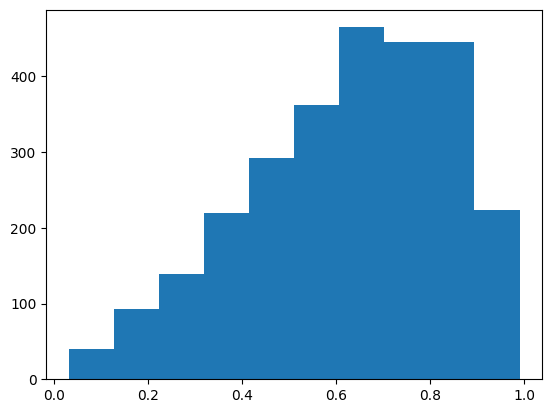

In [79]:
import matplotlib.pyplot as plt

plt.hist(predicted)

(array([ 37.,  88., 178., 298., 536., 591., 501., 312., 135.,  49.]),
 array([0.08584388, 0.17195213, 0.25806037, 0.34416863, 0.43027687,
        0.51638508, 0.60249335, 0.68860155, 0.77470982, 0.86081809,
        0.9469263 ]),
 <BarContainer object of 10 artists>)

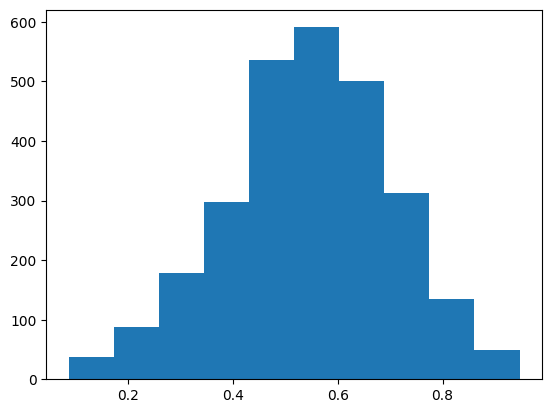

In [80]:
plt.hist(E_prediction_results_updated)

In [81]:
predicted_old = predicted.values.reshape(-1,1)

In [82]:
predicted_new = E_prediction_results_updated

In [83]:
np.round((abs(predicted_old - outcome_values) / (0.5 *(predicted_old + predicted_new))).mean(), 3)

np.float64(0.758)

In [84]:
np.round((abs(predicted_new - outcome_values) / (0.5 * (predicted_old + predicted_new))).mean(), 3)

np.float64(0.804)

In [85]:
test_df = pd.read_csv("https://raw.githubusercontent.com/aswinsp1102/DataAnalyticsDatasets/refs/heads/main/Hurling_Test_Data.csv")

In [86]:
test_df

,Date,Grade,Team 1,Elo_1,G_1,P_1,Sc_1,Team 2,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2
0,25-01-2025,League,Wexford,1939,0,12,12,Cork,2227,2,21,27,Y,2.000000,40,34.63%,-28,28
1,25-01-2025,League,Offaly,1592,0,19,19,Carlow,1429,1,16,19,Y,1.000000,40,80.87%,-12,12
2,25-01-2025,League,Dublin,1875,1,25,28,Antrim,1548,2,14,20,Y,1.400000,40,89.99%,6,-6
3,25-01-2025,League,Down,1191,2,19,25,Kildare,1364,0,22,22,Y,1.136364,40,47.35%,24,-24
4,25-01-2025,League,Tyrone,885,0,14,14,Derry,1198,1,13,16,Y,1.142857,40,32.07%,-15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,21-06-2025,All-Ireland,Dublin,1936,2,24,30,Limerick,2235,0,28,28,Y,1.071429,80,33.49%,57,-57
192,21-06-2025,All-Ireland,Galway,2068,2,17,23,Tipperary,2113,1,28,31,N,1.347826,80,44.84%,-48,48
193,05-07-2025,All-Ireland,Dublin,1993,2,21,27,Cork,2280,7,26,47,Y,1.740741,80,34.73%,-48,48
194,06-07-2025,All-Ireland,Kilkenny,2169,0,30,30,Tipperary,2161,4,20,32,N,1.066667,80,50.92%,-43,43


In [87]:
test_df['Team.1'] = test_df['Team 1']
test_df['Team.2'] = test_df['Team 2']

In [88]:
del test_df['Team 1']
del test_df['Team 2']

In [89]:
print(sorted(test_df['Team.1'].unique()))
print(sorted(test_df['Team.2'].unique()))
filtered_test_df = test_df[test_df['Team.2'].isin(team_indices.keys())]


print(sorted(filtered_test_df['Team.1'].unique()))
print(sorted(filtered_test_df['Team.2'].unique()))


filtered_test_df['Date'] = pd.to_datetime(filtered_test_df['Date'], format='%d-%m-%Y')


columns_to_check = ["Weight", "Grade", "Margin", "Team.1", "Team.2", "Sc_1", "Sc_2", "Home"]


filtered_test_df = filtered_test_df.dropna(subset=columns_to_check)

['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Clare', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'Fermanagh', 'Galway', 'Kerry', 'Kildare', 'Kilkenny', 'Lancashire', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'Tipperary', 'Tyrone', 'Warwickshire', 'Waterford', 'Westmeath', 'Wexford', 'Wicklow']
['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Clare', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'Fermanagh', 'Galway', 'Kerry', 'Kildare', 'Kilkenny', 'Lancashire', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Mayo', 'Meath', 'Monaghan', 'New York', 'Offaly', 'Roscommon', 'Sligo', 'Tipperary', 'Tyrone', 'Warwickshire', 'Waterford', 'Westmeath', 'Wexford', 'Wicklow']
['Antrim', 'Armagh', 'Carlow', 'Cavan', 'Clare', 'Cork', 'Derry', 'Donegal', 'Down', 'Dublin', 'Fermanagh', 'Galway', 'Kerry', 'Kildare', 'Kilkenny', 'Lancashire', 'Laois', 'Leitrim', 'Limerick', 'London', 'Longford', 'Louth', 'Mayo', 'Me

/tmp/ipython-input-1529523467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df['Date'] = pd.to_datetime(filtered_test_df['Date'], format='%d-%m-%Y')


In [90]:
test_df['Home'] = home_le.transform(test_df['Home'])

In [91]:
test_df

,Date,Grade,Elo_1,G_1,P_1,Sc_1,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Team.1,Team.2
0,25-01-2025,League,1939,0,12,12,2227,2,21,27,1,2.000000,40,34.63%,-28,28,Wexford,Cork
1,25-01-2025,League,1592,0,19,19,1429,1,16,19,1,1.000000,40,80.87%,-12,12,Offaly,Carlow
2,25-01-2025,League,1875,1,25,28,1548,2,14,20,1,1.400000,40,89.99%,6,-6,Dublin,Antrim
3,25-01-2025,League,1191,2,19,25,1364,0,22,22,1,1.136364,40,47.35%,24,-24,Down,Kildare
4,25-01-2025,League,885,0,14,14,1198,1,13,16,1,1.142857,40,32.07%,-15,15,Tyrone,Derry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,21-06-2025,All-Ireland,1936,2,24,30,2235,0,28,28,1,1.071429,80,33.49%,57,-57,Dublin,Limerick
192,21-06-2025,All-Ireland,2068,2,17,23,2113,1,28,31,0,1.347826,80,44.84%,-48,48,Galway,Tipperary
193,05-07-2025,All-Ireland,1993,2,21,27,2280,7,26,47,1,1.740741,80,34.73%,-48,48,Dublin,Cork
194,06-07-2025,All-Ireland,2169,0,30,30,2161,4,20,32,0,1.066667,80,50.92%,-43,43,Kilkenny,Tipperary


In [92]:
test_df['Outcome'] = np.where(
    test_df['Sc_1'] > test_df['Sc_2'], 1,
    np.where(
        test_df['Sc_1'] == test_df['Sc_2'], 0.5,
        0
    )
)

In [93]:
team_1_index_test = test_df['Team.1'].map(team_indices).values.reshape(-1, 1)
team_2_index_test = test_df['Team.2'].map(team_indices).values.reshape(-1, 1)
grade_index_test = test_df['Grade'].map(grade_indices).values.reshape(-1,1)
home_values_test = test_df['Home'].values.reshape(-1,1)
outcome_values_test = test_df['Outcome'].values.reshape(-1,1)
margin_values_test = test_df['Margin'].values.reshape(-1,1)

In [94]:
E_prediction_results_test = Optimization_Rating_model_updated.predict(
    x={
        'team1': team_1_index_test,
        'team2': team_2_index_test,
        'grade': grade_index_test,
        'home': home_values_test,
        'margin': margin_values_test,
        'outcome': outcome_values_test
    },
    batch_size = 1,
    verbose = 'auto'
)

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [95]:
np.round(((E_prediction_results_test - outcome_values_test)**2).mean(),3)

np.float64(0.195)

In [96]:
np.round(((test_df['T1_win_odds'].str.rstrip('%').astype(float) / 100 - test_df['Outcome'])**2).mean(),3)

np.float64(0.205)

In [97]:
predicted_old_test = (test_df['T1_win_odds'].str.rstrip('%').astype(float) / 100).values.reshape(-1,1)

In [98]:
len(E_prediction_results_test)

196

In [99]:
np.round((abs(predicted_old_test - outcome_values_test) / ((predicted_old_test + E_prediction_results_test))).mean(), 3)

np.float64(0.376)

In [100]:
np.round((abs(E_prediction_results_test - outcome_values_test) / (predicted_old_test + E_prediction_results_test)).mean(), 3)

np.float64(0.395)

In [101]:
for key,value in team_indices.items():
  print(f"{key}: {rating_layer_updated.team_ratings[value]:.0f}")

Antrim: 1088
Armagh: 283
Carlow: 1180
Cavan: 60
Clare: 2010
Cork: 2251
Derry: 925
Donegal: 617
Down: 928
Dublin: 1805
Fermanagh: -101
Fingal: 548
Galway: 2001
Kerry: 803
Kildare: 1275
Kilkenny: 2097
Lancashire: -515
Laois: 1132
Leitrim: -177
Limerick: 2302
London: 678
Longford: -52
Louth: 79
Mayo: 670
Meath: 639
Monaghan: -87
Offaly: 1358
Roscommon: 545
Sligo: 153
South Down: 190
Tipperary: 2108
Tyrone: 253
Warwickshire: -97
Waterford: 1827
Westmeath: 1003
Wexford: 1807
Wicklow: 482


In [102]:
test_df.tail()

,Date,Grade,Elo_1,G_1,P_1,Sc_1,Elo_2,G_2,P_2,Sc_2,Home,Margin,Weight,T1_win_odds,Result_T1,Result_T2,Team.1,Team.2,Outcome
191,21-06-2025,All-Ireland,1936,2,24,30,2235,0,28,28,1,1.071429,80,33.49%,57,-57,Dublin,Limerick,1.0
192,21-06-2025,All-Ireland,2068,2,17,23,2113,1,28,31,0,1.347826,80,44.84%,-48,48,Galway,Tipperary,0.0
193,05-07-2025,All-Ireland,1993,2,21,27,2280,7,26,47,1,1.740741,80,34.73%,-48,48,Dublin,Cork,0.0
194,06-07-2025,All-Ireland,2169,0,30,30,2161,4,20,32,0,1.066667,80,50.92%,-43,43,Kilkenny,Tipperary,0.0
195,20-07-2025,All-Ireland,2328,1,18,21,2204,3,27,36,0,1.714286,80,63.90%,-88,88,Cork,Tipperary,0.0


In [103]:
Optimization_Rating_model_updated.predict(
    x={
        'team1': team_1_index_test[195:],
        'team2': team_2_index_test[195:],
        'grade': grade_index_test[195:],
        'home': home_values_test[195:],
        'margin': margin_values_test[195:],
        'outcome': outcome_values_test[195:]
    },
    batch_size = 1,
    verbose = 'auto'
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.5248415]], dtype=float32)

In [104]:
for key,value in team_indices.items():
  print(f"{key}: {rating_layer_updated.team_ratings[value]:.0f}")

Antrim: 1088
Armagh: 283
Carlow: 1180
Cavan: 60
Clare: 2010
Cork: 2204
Derry: 925
Donegal: 617
Down: 928
Dublin: 1805
Fermanagh: -101
Fingal: 548
Galway: 2001
Kerry: 803
Kildare: 1275
Kilkenny: 2097
Lancashire: -515
Laois: 1132
Leitrim: -177
Limerick: 2302
London: 678
Longford: -52
Louth: 79
Mayo: 670
Meath: 639
Monaghan: -87
Offaly: 1358
Roscommon: 545
Sligo: 153
South Down: 190
Tipperary: 2155
Tyrone: 253
Warwickshire: -97
Waterford: 1827
Westmeath: 1003
Wexford: 1807
Wicklow: 482


In [105]:
grade_indices

{'All-Ireland': 0,
 'League': 1,
 'Provincial': 2,
 'Qualifier': 3,
 'Secondary': 4,
 'Ulster': 5}

In [106]:
ape_results = abs(predicted_new - outcome_values) / ((predicted_old + predicted_new) / 2)

(array([ 40.,  93., 139., 219., 292., 362., 465., 446., 445., 224.]),
 array([0.0311 , 0.12705, 0.223  , 0.31895, 0.4149 , 0.51085, 0.6068 ,
        0.70275, 0.7987 , 0.89465, 0.9906 ]),
 <BarContainer object of 10 artists>)

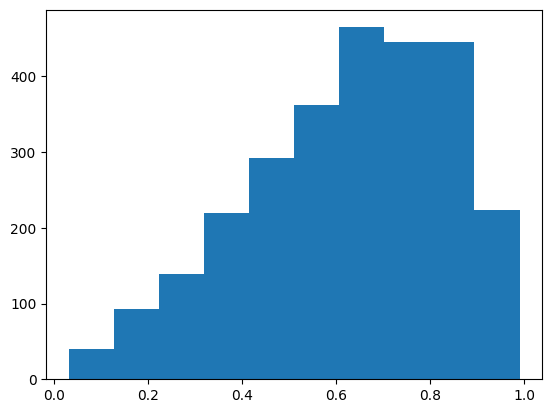

In [107]:
plt.hist(predicted_old)

In [108]:
sum(ape_results)/len(ape_results)

array([0.80402915])

In [121]:
ape_old_results = abs(predicted_old - outcome_values) / ((predicted_old + predicted_new) / 2)

In [122]:
sum(ape_old_results)/len(ape_old_results)

array([0.75787049])

In [109]:
filtered_ape_results_cat1 = ape_results[(predicted_new >= 0.4) & (predicted_new <= 0.6)]
filtered_ape_results_cat2 = ape_results[((predicted_new > 0.6) & (predicted_new <= 0.8)) | ((predicted_new >= 0.2) & (predicted_new < 0.4))]
filtered_ape_results_cat3 = ape_results[((predicted_new > 0.8) & (predicted_new <= 1.0)) | ((predicted_new >= 0.0) & (predicted_new < 0.2))]

In [119]:
print("MAPE OF Predicted new expectation in [0.4,0.6) :", sum(filtered_ape_results_cat1) / len(filtered_ape_results_cat1))
print("MAPE OF Predicted new expectation in [0.2,0.4) U (0.6,0.8] :", sum(filtered_ape_results_cat2) / len(filtered_ape_results_cat2))
print("MAPE OF Predicted new expectation in [0.0,0.2) U (0.8,1.0] :", sum(filtered_ape_results_cat3) / len(filtered_ape_results_cat3))

MAPE OF Predicted new expectation in [0.4,0.6) : 0.8647041752637886
MAPE OF Predicted new expectation in [0.2,0.4) U (0.6,0.8] : 0.7779410493612648
MAPE OF Predicted new expectation in [0.0,0.2) U (0.8,1.0] : 0.587413901479916


In [111]:
len(filtered_ape_results_cat1) + len(filtered_ape_results_cat2) + len(filtered_ape_results_cat3)

2725

In [123]:
filtered_ape_results_cat1_old = ape_old_results[(predicted_old >= 0.4) & (predicted_old <= 0.6)]
filtered_ape_results_cat2_old = ape_old_results[((predicted_old > 0.6) & (predicted_old <= 0.8)) | ((predicted_old >= 0.2) & (predicted_old < 0.4))]
filtered_ape_results_cat3_old = ape_old_results[((predicted_old > 0.8) & (predicted_old <= 1.0)) | ((predicted_old >= 0.0) & (predicted_old < 0.2))]

In [124]:
print("MAPE OF Predicted old expectation in [0.4,0.6) :", sum(filtered_ape_results_cat1_old) / len(filtered_ape_results_cat1_old))
print("MAPE OF Predicted old expectation in [0.2,0.4) U (0.6,0.8] :", sum(filtered_ape_results_cat2_old) / len(filtered_ape_results_cat2_old))
print("MAPE OF Predicted old expectation in [0.0,0.2) U (0.8,1.0] :", sum(filtered_ape_results_cat3_old) / len(filtered_ape_results_cat3_old))

MAPE OF Predicted old expectation in [0.4,0.6) : 0.9550075751131252
MAPE OF Predicted old expectation in [0.2,0.4) U (0.6,0.8] : 0.8352603644530557
MAPE OF Predicted old expectation in [0.0,0.2) U (0.8,1.0] : 0.4556033311130105


The modified model was able to improve its predictions in the regions of predictions were the outcome expectation was ranging from 0.2 to 0.8 where the team strength was comparitively closer to each other. For the extreme results predictions were a team is highly expected to win or lose, the standard ELO model was seemingly performing better than the modified one.